In [1]:
import matplotlib
# %matplotlib inline
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
import matplotlib.pyplot as plt

import SUITPy as suit
import surfAnalysisPy as sa
import nibabel as nb
import nitools as nt

import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as am
import selective_recruitment.plotting as splotting
import selective_recruitment.scripts.script_overlap_map_wm as soverlap
import selective_recruitment.plotting as splotting
import selective_recruitment.globals as gl

from statsmodels.stats.anova import AnovaRM # perform F test
from matplotlib.colors import LinearSegmentedColormap
from nilearn import plotting
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')


In [2]:
wkdir = '/srv/diedrichsen/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'
# create an instance of the dataset class
Data = fdata.get_dataset_class(gl.base_dir, dataset="WMFS")
# get list of subjects
T = Data.get_participants()
subject_list = list(T.participant_id.values)
subject_list.append("group")

# Load and recall effects
* Which regions of the cerebellum and cortex show recall effect?
* Which regions of the cerebellum and cortex show load effect?

## 1. Evaluate overlap between load and recall effects
The goal is to find the conjunction between two contrasts of interests: contrast that shows the load effect and contrast that shows the recall effect.

Steps:
1. for each subject, get load and recall contrast
    * load: Load 6 - load 2
    * recall: backwards - forwards
2. do group analysis on the two contrasts.
    * in each contrast, on the group level, which voxels survive a 1sample ttest (no multiple comparison corrections yet)

### 1.1 display load and recall effects

In [3]:
phase = "enc"
effect = "dir"
soverlap.plot_contrast_cerebellum(subject = "group", phase = phase, effect = effect, save_svg = True, smooth = False)
soverlap.plot_contrast_cortex(subject = "group", phase = phase, effect = effect, save_svg = True, smooth = False)

TypeError: plot_contrast_cerebellum() got an unexpected keyword argument 'smooth'

### 1.2 Get the reliability of the effects 
How reliable are the effects across subjects?
1. for each "half" calculate the effect (load/recall)
2. calculate correlations between the two effects between the halves.

In [5]:
# D_split_rel = soverlap.get_summary_reliability(smooth = False, type = "CondRun")
# D_split_rel.to_csv(f"{wkdir}/load_recall_overlap_reliability.tsv", sep = "\t")
D_split_rel = soverlap.get_effect_reliability_summary(smooth = True, verbose = False, subtract_mean = True)
D_split_rel.to_csv(f"{wkdir}/load_recall_overlap_reliability.tsv", sep = "\t")

,Unnamed: 0,dataset,ses_id,phase,effect,atlas,R,a_cron,sn
0,0,WMFS,ses-02,Enc,load,fs32k,0.864073,0.926454,sub-01
1,0,WMFS,ses-02,Enc,recall_dir,fs32k,0.544543,0.689716,sub-01
2,0,WMFS,ses-02,Ret,load,fs32k,0.791459,0.880019,sub-01
3,0,WMFS,ses-02,Ret,recall_dir,fs32k,0.107599,0.191642,sub-01
4,1,WMFS,ses-02,Enc,load,fs32k,0.426432,0.597541,sub-02
...,...,...,...,...,...,...,...,...,...
123,14,WMFS,ses-02,Ret,recall_dir,SUIT3,-0.139239,-0.311488,sub-15
124,15,WMFS,ses-02,Enc,load,SUIT3,0.037624,0.062557,sub-16
125,15,WMFS,ses-02,Enc,recall_dir,SUIT3,0.151476,0.252486,sub-16
126,15,WMFS,ses-02,Ret,load,SUIT3,0.019046,0.033432,sub-16


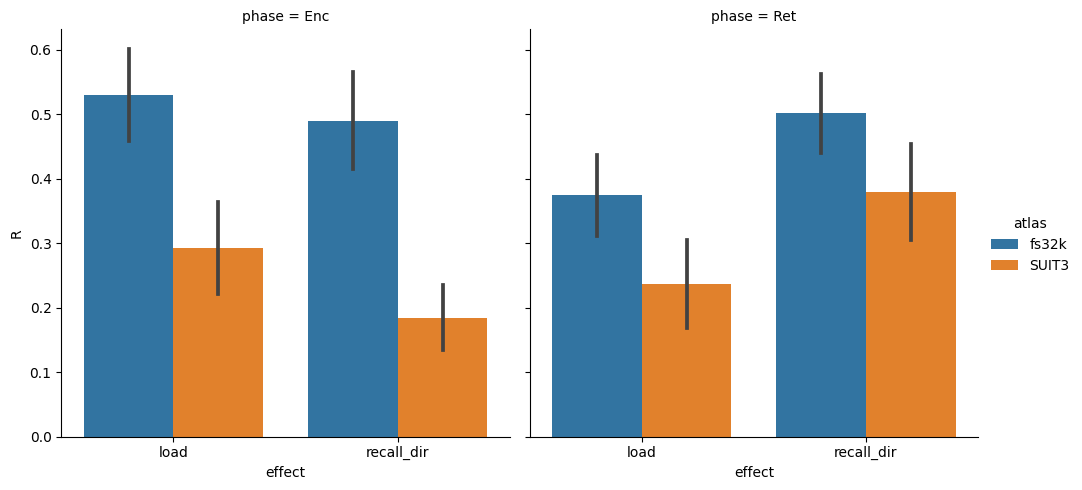

In [22]:
# without smoothing
D1 = pd.read_csv(f"{wkdir}/load_recall_overlap_reliability.tsv", sep = '\t')
# put the dataframe into scatterplot
sns.catplot(D1, 
            x = "effect", 
            y = "R", 
            hue = "atlas", 
            col = "phase", 
            errorbar= 'se', 
            kind = 'bar')
plt.savefig(f"{wkdir}/figures/load_recall_reliability.png")

### 1.3 Visualize the overlap 
Options:
1. Create rgba map of values using load and recall contrasts using the group
    * the goal here would be to just show the overlap between the two contrasts and describe (summarize) the overlap between the two contrasts. More analysis will quantify what we observe (for example the correlation plots in the previous section).
2. Do a conjunction analysis like how people normally do it: 
    * get the maps for each subject.
    * Do group t-test on the overlap between the maps
    * Show the conjunction map + areas that are uniquely activated by each effect. 

#### 1.3.1 visualization using rgba values: 
red:regions where recall effect exists

purple: regions where both recall and load effects exist

blue: regions where load effect exists

##### During encoding

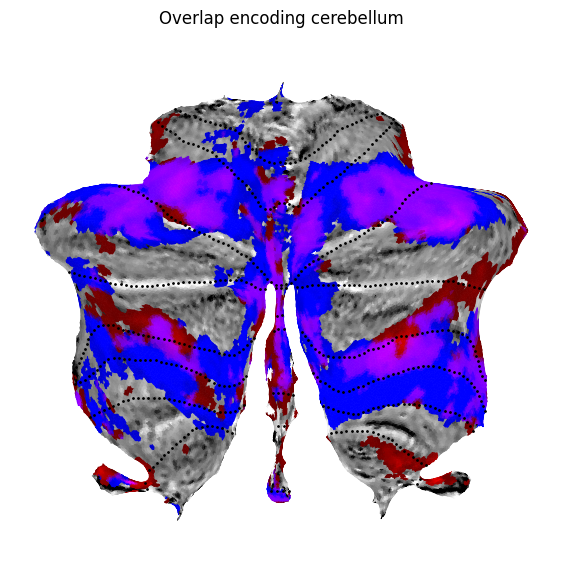

In [10]:
ax = soverlap.plot_overlap_cerebellum(subject = "group", 
                                      phase = 0, 
                                      smooth = True, 
                                      scale = [0.05,1,0.05], 
                                      threshold = [0.02,1,0.04])
ax.set_title("Overlap encoding cerebellum")
plt.savefig(f"{wkdir}/figures/cerebellum_overlap_encoding.png")

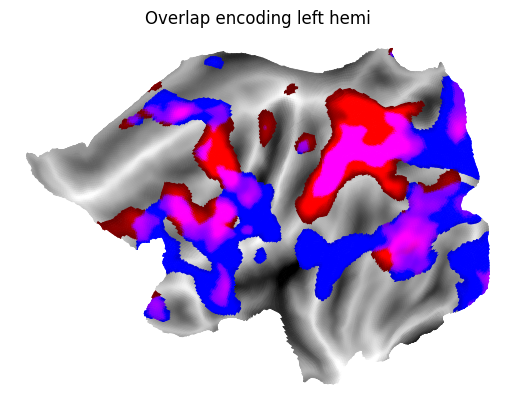

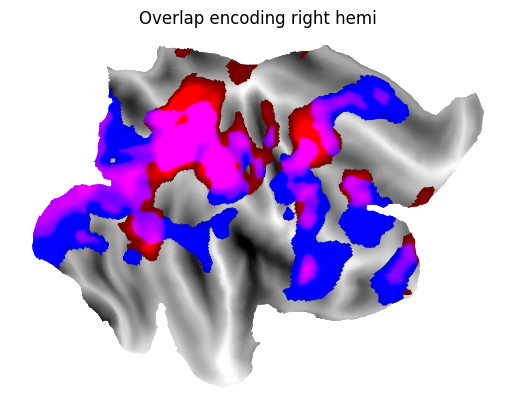

In [9]:
ax = soverlap.plot_overlap_cortex(subject = "group", 
                                      phase = 0, 
                                      smooth = True, 
                                      scale = [0.05,1,0.05], 
                                      threshold = [0.02,1,0.04])
ax[0].set_title("Overlap encoding left hemi")
ax[0].figure.savefig(f"{wkdir}/figures/cortexLeftFlat_overlap_encoding.png")
ax[1].set_title("Overlap encoding right hemi")
ax[1].figure.savefig(f"{wkdir}/figures/cortexRightFlat_overlap_encoding.png")


##### During retrieval

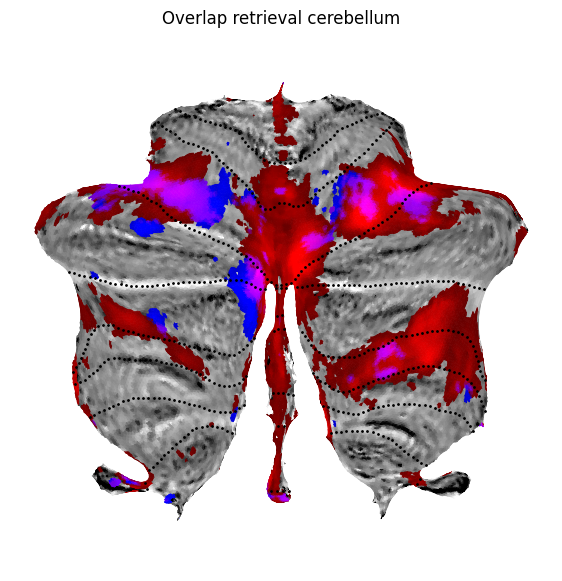

In [11]:
ax = soverlap.plot_overlap_cerebellum(subject = "group", 
                                      phase = 1, 
                                      smooth = True,
                                      scale = [0.05,1,0.05], 
                                      threshold = [0.02,1,0.04])
ax.set_title("Overlap retrieval cerebellum")
plt.savefig(f"{wkdir}/figures/cerebellum_overlap_retrieval.png")

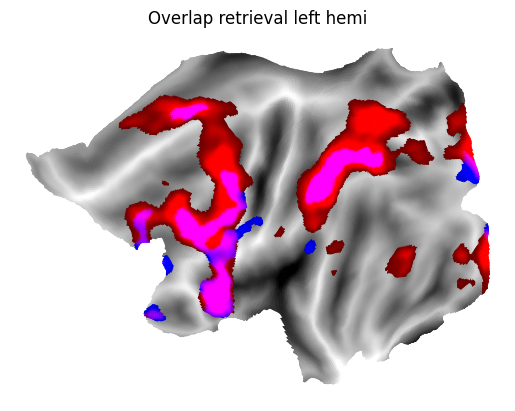

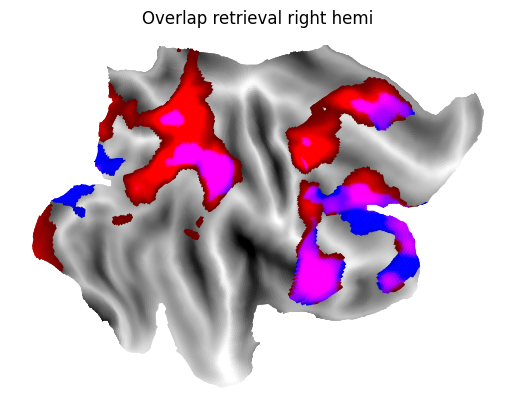

In [12]:
ax = soverlap.plot_overlap_cortex(subject = "group", 
                                      phase = 1, 
                                      smooth = True, 
                                      scale = [0.05,1,0.05], 
                                      threshold = [0.02,1,0.04])
ax[0].set_title("Overlap retrieval left hemi")
ax[0].figure.savefig(f"{wkdir}/figures/cortexLeftFlat_overlap_retrieval.png")
ax[1].set_title("Overlap retrieval right hemi")
ax[1].figure.savefig(f"{wkdir}/figures/cortexRightFlat_overlap_retrieval.png")

### 1.4 Quantify the overlap 
1. for each subject, get the map for load effect
2. for each subject, get the map for recall effect
3. for each subject, quantify how similar the two maps are by correlating them.

In [13]:
# without smoothing
D_overlap_corr = soverlap.get_overlap_summary(type = "CondAll", smooth = False)
D_overlap_corr.to_csv(f"{wkdir}/load_recall_overlap_corr.tsv", sep = "\t")

,Unnamed: 0,dataset,ses_id,phase,atlas,R,sn
0,0,WMFS,ses-02,Enc,fs32k,0.282796,sub-01
1,0,WMFS,ses-02,Ret,fs32k,-0.179812,sub-01
2,0,WMFS,ses-02,Enc,fs32k,0.197669,sub-02
3,0,WMFS,ses-02,Ret,fs32k,0.184809,sub-02
4,0,WMFS,ses-02,Enc,fs32k,-0.169288,sub-03
...,...,...,...,...,...,...,...
59,0,WMFS,ses-02,Ret,SUIT3,0.505262,sub-14
60,0,WMFS,ses-02,Enc,SUIT3,0.330334,sub-15
61,0,WMFS,ses-02,Ret,SUIT3,0.212555,sub-15
62,0,WMFS,ses-02,Enc,SUIT3,0.220909,sub-16


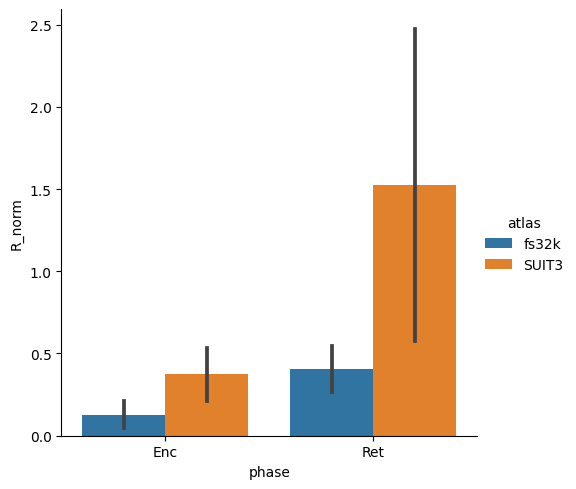

In [21]:
# without smoothing
D2 = pd.read_csv(f"{wkdir}/load_recall_overlap_corr.tsv", sep = "\t")

# calculate geometric mean of reliability
D1_load = D1.loc[D1.effect == "load"]
D1_dir = D1.loc[D1.effect == "recall_dir"]
D2["geo_alpha"] = np.sqrt(D1_load.a_cron.values*D1_dir.a_cron.values)
# normalize overlap corr
D2["R_norm"] = D2["R"]/D2["geo_alpha"]
D2["R_norm"] = np.nan_to_num(D2["R_norm"])


sns.catplot(D2.loc[(D2.sn != "group")], x = "phase", 
            y = "R_norm", 
            hue = "atlas", 
            errorbar= 'se', 
            kind = 'bar')
plt.savefig(f"{wkdir}/figures/overlap_corr.png")


In [ ]:
# do tests
print(AnovaRM(data=D2, depvar="R_norm",
              subject='sn', within=['atlas', 'phase'], aggregate_func = np.mean).fit())

#### 1.4.2 conjunction analysis (group tests)

In [ ]:
phase = 0
t_val_load, t_val_recall = soverlap.conjunction_ana_cortex(type = "CondAll", phase = phase, smooth = True, atlas_space = 'fs32k')
t_val_load_cereb, t_val_recall_cereb = soverlap.conjunction_ana_cerebellum(type = "CondAll", phase = phase, smooth = True, atlas_space = 'SUIT3')

In [ ]:
threshold = 2
surfs = [Data.atlas_dir + f'/tpl-fs32k/tpl_fs32k_hemi-{h}_inflated.surf.gii' for i, h in enumerate(['L', 'R'])]
fig = plotting.plot_surf_stat_map(
                                        surfs[0], t_val_load[0], hemi='left',
                                        colorbar=True, 
                                        view = 'lateral',
                                        engine='plotly',
                                        title = f'load effect {phase}',
                                        symmetric_cbar = True,
                                        threshold = 5,
                                        vmax = 10 , 
                                        cmap = 'jet'
                                        # cscale = []
                                    )

ax = fig.figure
ax.show()

In [ ]:
fig = plotting.plot_surf_stat_map(
                                        surfs[0], t_val_recall[0], hemi='left',
                                        colorbar=True, 
                                        view = 'lateral',
                                        engine='plotly',
                                        title = f'recall effect {phase}',
                                        symmetric_cbar = True,
                                        threshold = threshold, 
                                        vmax = 10, 
                                        cmap = 'jet'
                                    )

ax = fig.figure
ax.show()

In [ ]:
atlas, ainfo = am.get_atlas("SUIT3", Data.atlas_dir)
load_nii = atlas.data_to_nifti(t_val_load_cereb.reshape(-1, 1).T)
recall_nii = atlas.data_to_nifti(t_val_recall_cereb.reshape(-1, 1).T)

# convert to surf for plotting on flatmap
load_flat = suit.flatmap.vol_to_surf([load_nii], stats='nanmean', space = 'SUIT')
recall_flat = suit.flatmap.vol_to_surf([recall_nii], stats='nanmean', space = 'SUIT')

load_flat[np.abs(load_flat)<threshold] = np.nan
recall_flat[np.abs(recall_flat)<threshold] = np.nan

In [ ]:
ax = suit.flatmap.plot(data=load_flat, 
                      render="matplotlib", 
                      hover='auto', 
                      colorbar = True, 
                      bordersize = 1,
                      cscale = [-6, 6]
                      )

# ax.show()
# ax.update_layout(title = {'text':f'load effect {phase}', 
#                             'y':0.95,
#                             'x':0.5,
#                             'xanchor': 'center'})
# ax.show()

In [ ]:
ax = suit.flatmap.plot(data=recall_flat, 
                      render="matplotlib", 
                      hover='auto', 
                      colorbar = True, 
                      bordersize = 1, 
                      cscale = [-5, 5])

# ax.show()
# ax.update_layout(title = {'text':f'recall effect {phase}', 
#                             'y':0.95,
#                             'x':0.5,
#                             'xanchor': 'center'})
# ax.show()

# 2. Relationship between activations within ROIs

## 2.1. imshow pcm G with cross validating over subjects

In [ ]:
G, Ginf, W, Glam, colors_D = soverlap.calc_G_group(center = False, reorder = ['side', 'anterior'])
fig, ax = plt.subplots()
plt.imshow(G, cmap = 'jet')
plt.colorbar()
plt.clim([-0.003, 0.003])
ax.set_xticks(Ginf['region_id'].values)
ax.set_yticks(Ginf['region_id'].values)
ax.set_xticklabels(labels = Ginf['region_name'].values, rotation = 90)
ax.set_yticklabels(labels = Ginf['region_name'].values, rotation = 0)

# print(G)

In [ ]:
# splotting.plot_MDS(W[:, 0], W[:, 1], Ginf, colors_D, text_size = 'small', text_weight = 'regular')
# plot variance explained
fig = plt.figure()
plt.plot(Glam,'-o')

In [ ]:
splotting.plot_MDS(W[:, 0], W[:, 1], Ginf, colors_D, text_size = 'small', text_weight = 'regular')

In [ ]:
splotting.plot_MDS(W[:, 0], W[:, 2], Ginf, colors_D, text_size = 'small', text_weight = 'regular')

In [ ]:

splotting.plot_MDS(W[:, 1], W[:, 2], Ginf, colors_D, text_size = 'small', text_weight = 'regular')

## 2.2. scatterplot with rois on x and y axes

In [ ]:
df_path = os.path.join(wkdir, "ROI_NettekovenSym68c32AP_conn_reg.tsv")
df4 = pd.read_csv(df_path, sep="\t")

In [ ]:
# Generate the labels and colors for all scatterplot
label_dict={1:'Enc2F', 2:'Ret2F',
            3:'Enc2B', 4:'Ret2B',
            5:'Enc4F', 6:'Ret4F',
            7:'Enc4B', 8:'Ret4B',
            9:'Enc6F', 10:'Ret6F',
            11:'Enc6B',12:'Ret6B',
            13:'rest'}
marker_dict = {1:'o',2:'X',
                3:'o',4:'X',
                5:'o',6:'X',
                7:'o',8:'X',
                9:'o',10:'X',
                11:'o',12:'X',
                13:'s'}
color_dict  = {1:'b',2:'b',
                3:'r',4:'r',
                5:'b',6:'b',
                7:'r',8:'r',
                9:'b',10:'b',
                11:'r',12:'r',
                13:'g'}

In [ ]:
parcellation = "NettekovenSym68c32AP"
roi_name1 = "D1R_P"
ax, roi_num1 = splotting.plot_parcellation(parcellation, roi_name1)
roi_name2 = "D3R_A"
ax, roi_num2 = splotting.plot_parcellation(parcellation, roi_name2)
roi_name3 = "D3R_P"
ax, roi_num3 = splotting.plot_parcellation(parcellation, roi_name3)
dd = df4.loc[(df4.roi == roi_num1) | (df4.roi == roi_num2) | (df4.roi == roi_num3)]
dd['roi1_act'] = dd["Y"].loc[dd.roi == roi_num1]
dd['roi2_act'] = dd["Y"].loc[dd.roi == roi_num2]
dd['roi3_act'] = dd["Y"].loc[dd.roi == roi_num3]
splotting.make_scatterplot2(dd,split='cond_num',
            xlabel = "roi2_act", 
            ylabel = "roi3_act", 
            xerr = None, 
            yerr = None,
            labels=label_dict,
            markers=marker_dict,
            colors=color_dict)